In [1]:
import os
from datasets import load_dataset
import datasets
from datasets import Value, Sequence
import sys
import math
import transformers
import json
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np
from utils import cache_dir, change_name, set_global_path, rank, get_results_per_task, get_model_avg, draw_avg_line

plt.rcParams.update({
    "font.size": 14,       
    "axes.labelsize": 16,  
    "axes.titlesize": 18,  
    "legend.fontsize": 18, 
    "lines.linewidth": 2   
})

/users/PDS0352/wyang107/miniconda3/envs/lceg2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /users/PDS0352/wyang107/.cache/huggingface/token
Login successful


## Motivation

### Results of longbench

In [2]:
def draw_longbench(model, dataset_re, results_all, show_tasks, x_map, save=False):
    colors = plt.get_cmap('tab10', len(results_all.keys()))
    fig, axes = plt.subplots(1, len(dataset_re), figsize=(15, 3), dpi=400)
    color_path = {key:i for i, key in enumerate(results_all.keys())}
    for key_i, dataset in enumerate(show_tasks):
        model_re = dataset_re[dataset]
        res = model_re[model]
        x, y, sizes = [s[0]*1000 for s in res],[s[1] for s in res],[s[2]*8 for s in res]
        axes[key_i].plot(x, [results_all[model][dataset]]*len(x), linestyle='--', color=colors(color_path[model]))
        axes[key_i].scatter(x, y, s=sizes, color=colors(color_path[model]), marker='*' ,alpha=0.5,  label=change_name(model) if dataset == 'multi_news' else "")
        axes[key_i].set_xticks([v*1000 for v in x_map.values()], list(x_map.keys()))
        axes[key_i].set_xlabel(change_name(dataset), fontweight='bold',  fontsize=14,)
        axes[key_i].set_title(model)
        if key_i == 0:
            axes[key_i].set_ylabel("score")
        axes[key_i].grid(True, linestyle='--', linewidth=0.4)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85) 
    if save:
        plt.savefig(f"different_length_{model}.pdf", format="pdf", dpi=600, bbox_inches="tight")
    plt.show()

In [17]:
path = {
        'ntk':'llama2-7b-hf-slimpajama-ntk-32k', 
        'pi': 'llama2-7b-hf-slimpajama-pi-32k',
        'lminfinite': 'llama2-7b-hf-lminfinite',
        'longlora': 'llama2-7b-hf-slimpajama-longlora-32k',
        'yarn': 'llama2-7b-hf-slimpajama-yarn-32k',
        }
show_tasks = ['multi_news', 'qasper',  'gov_report']
results, results_all = dict(), dict()
for model, p in path.items():
    results[model]= json.load(open(os.path.join(set_global_path('./preds/pred_old'), p,'result.json'), 'r'))
    results_all[model]= json.load(open(os.path.join(set_global_path('./preds/pred_old'), p,'result_all.json'), 'r'))


In [18]:
from collections import defaultdict
x_map = {'0-2k':2, '2-4k':4, '4-6k':6, '6-8k':8, '8k+':10}
dataset_re = defaultdict(dict)
for model, result in results.items():
    for dataset in result.keys():
        if dataset in show_tasks:
            # print(model, dataset, result[dataset])
            for x, res in result[dataset].items():
                if model not in dataset_re[dataset]:
                    dataset_re[dataset][model]=[(x_map[x], res['score'], res['num'])]
                else:
                    dataset_re[dataset][model].append((x_map[x], res['score'], res['num']))
print(dataset_re.keys())

dict_keys(['qasper', 'gov_report', 'multi_news'])


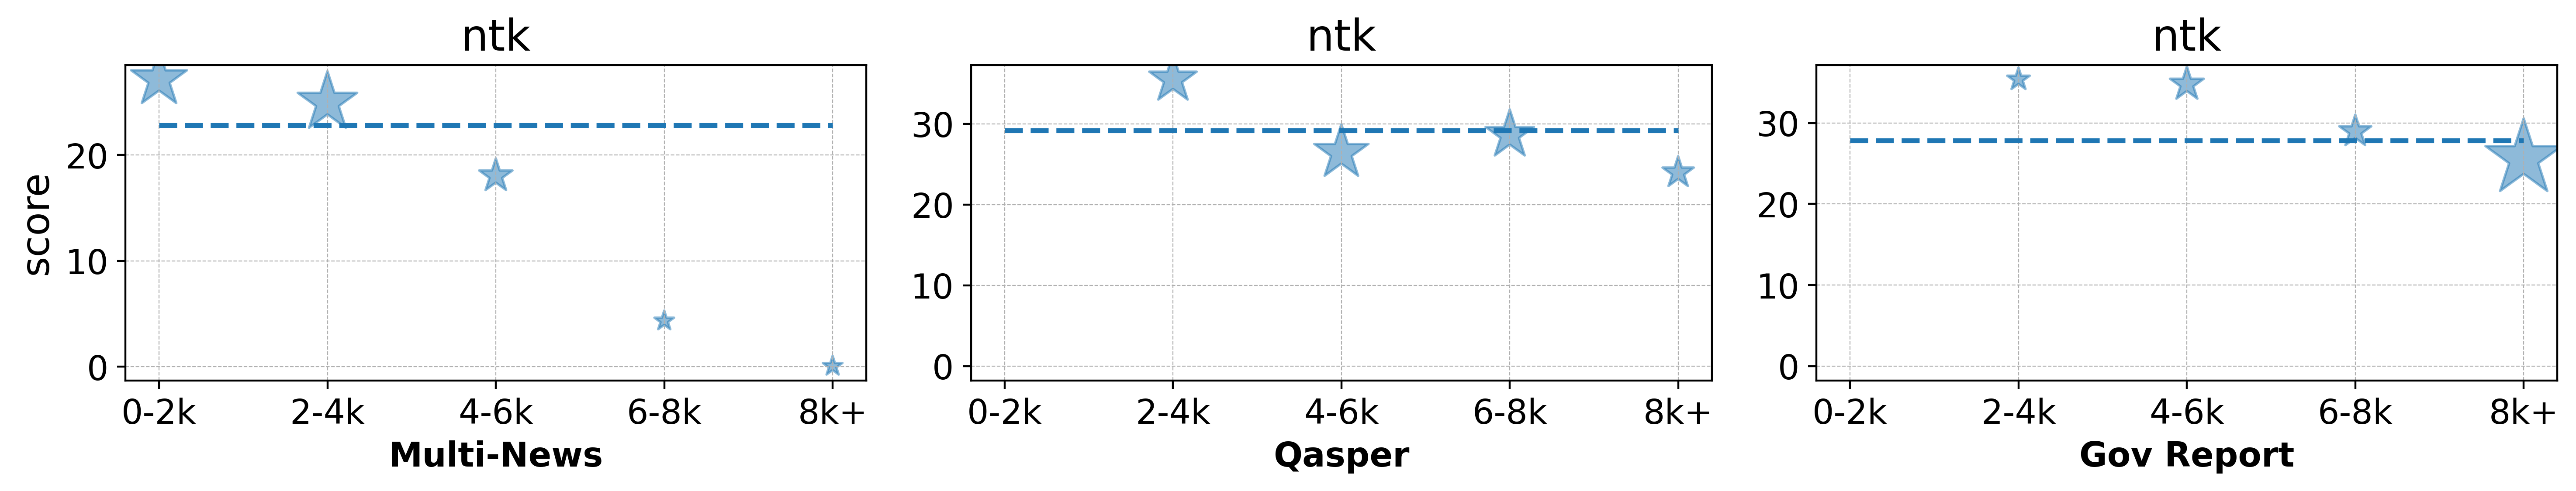

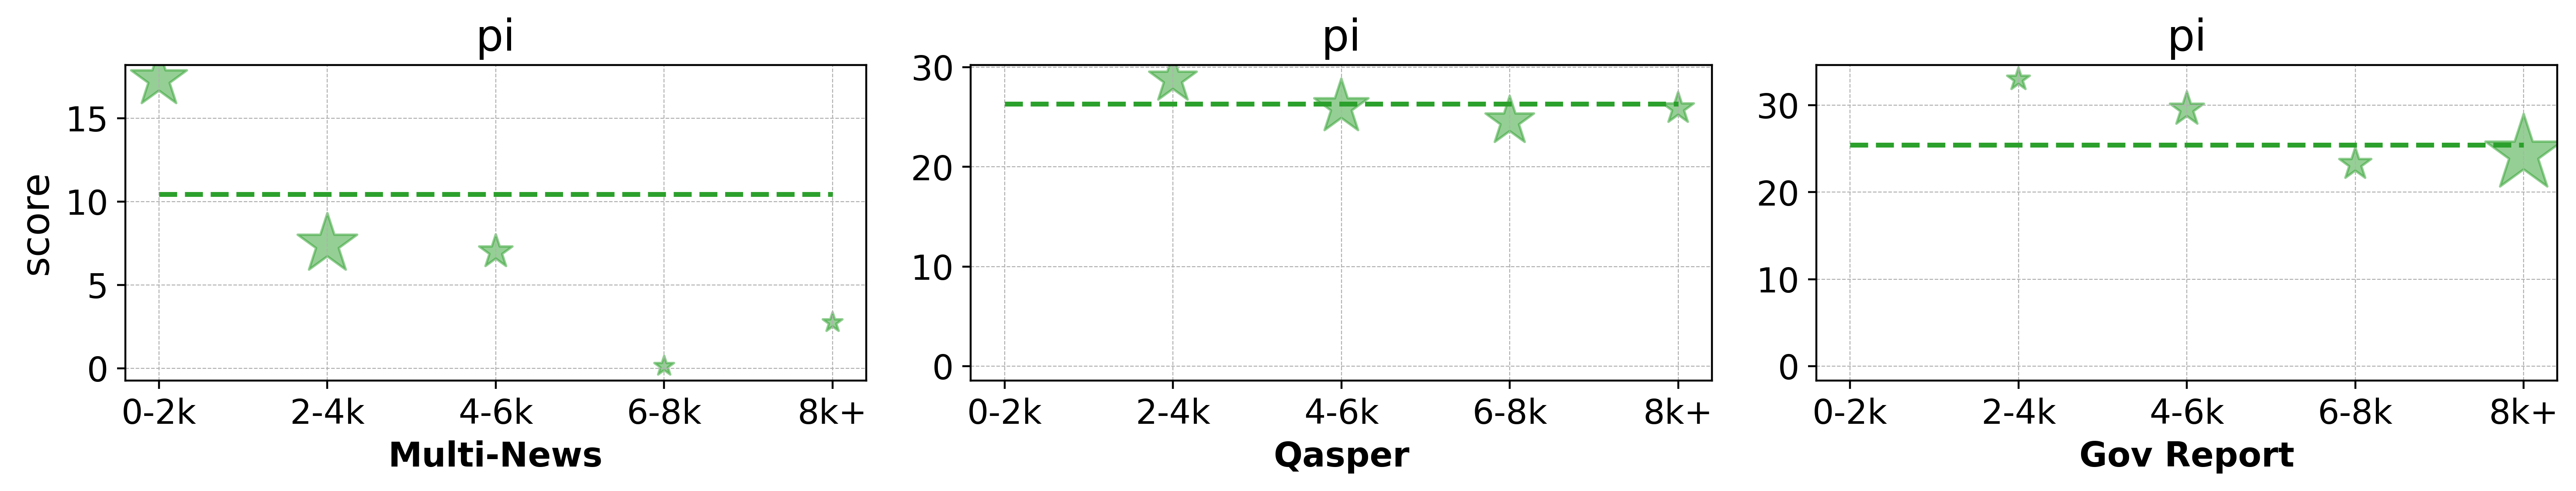

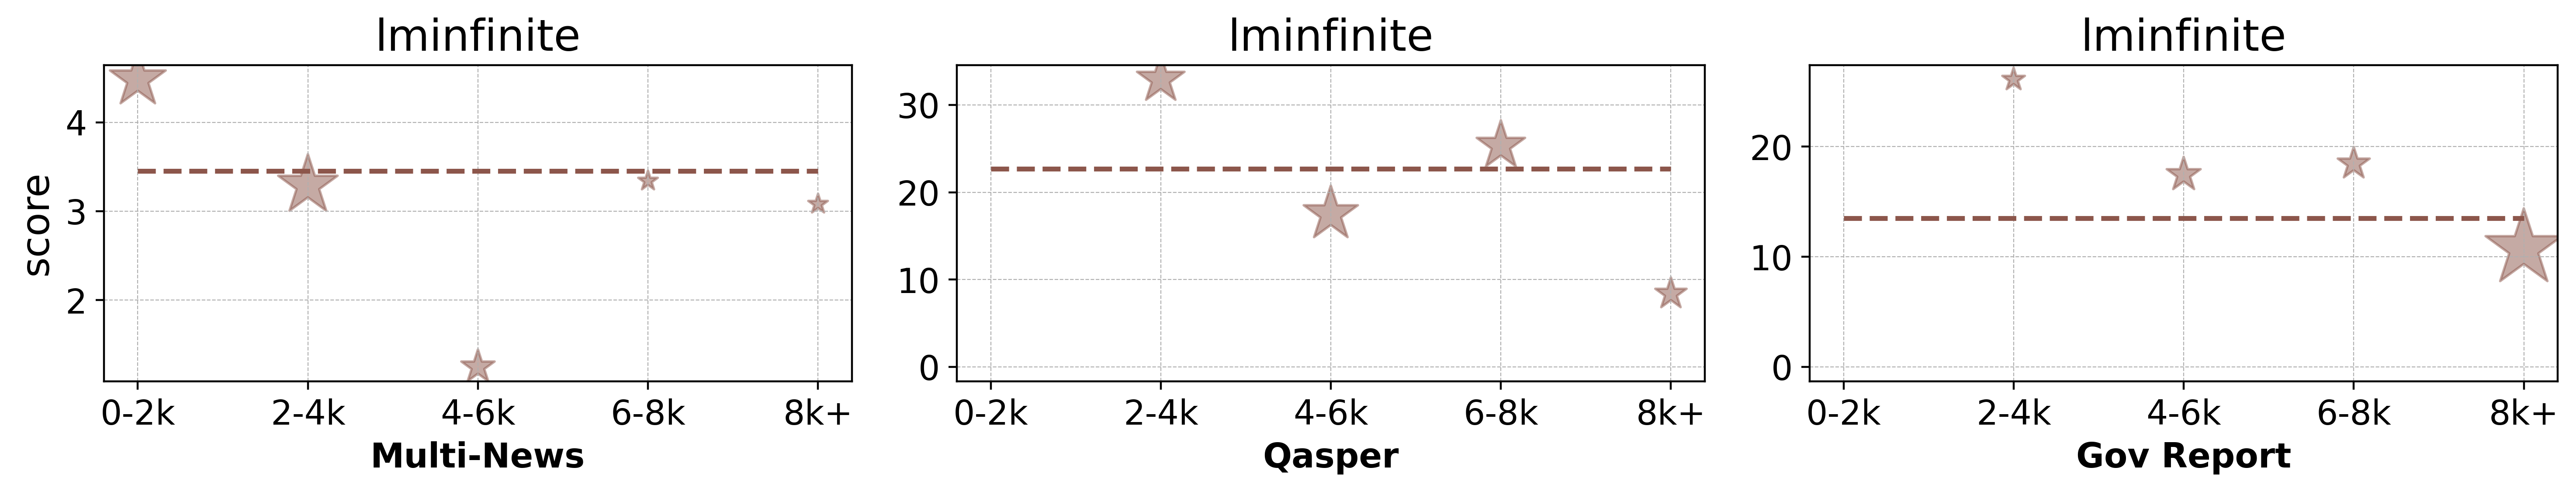

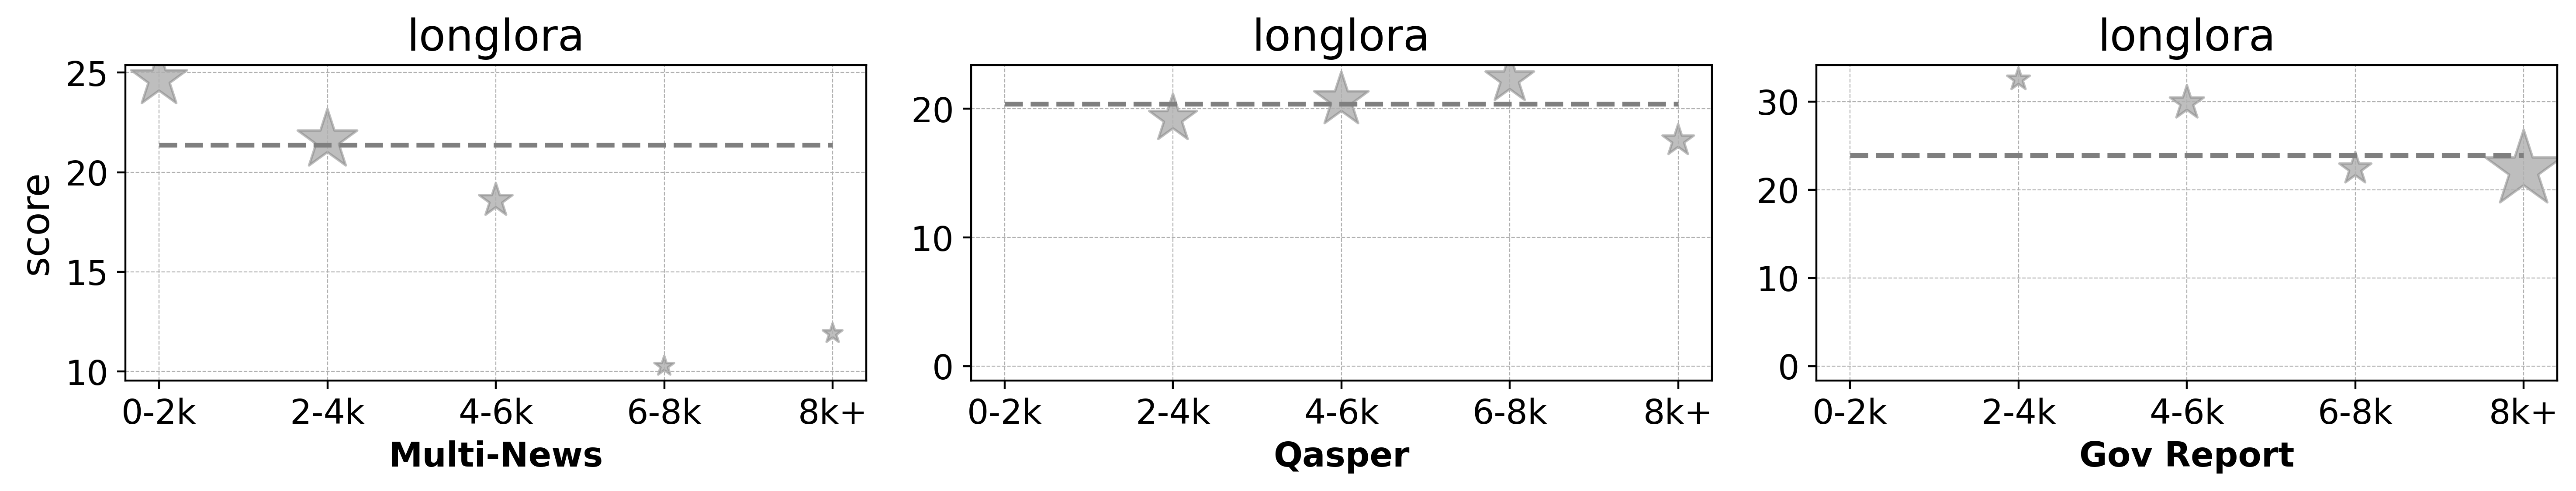

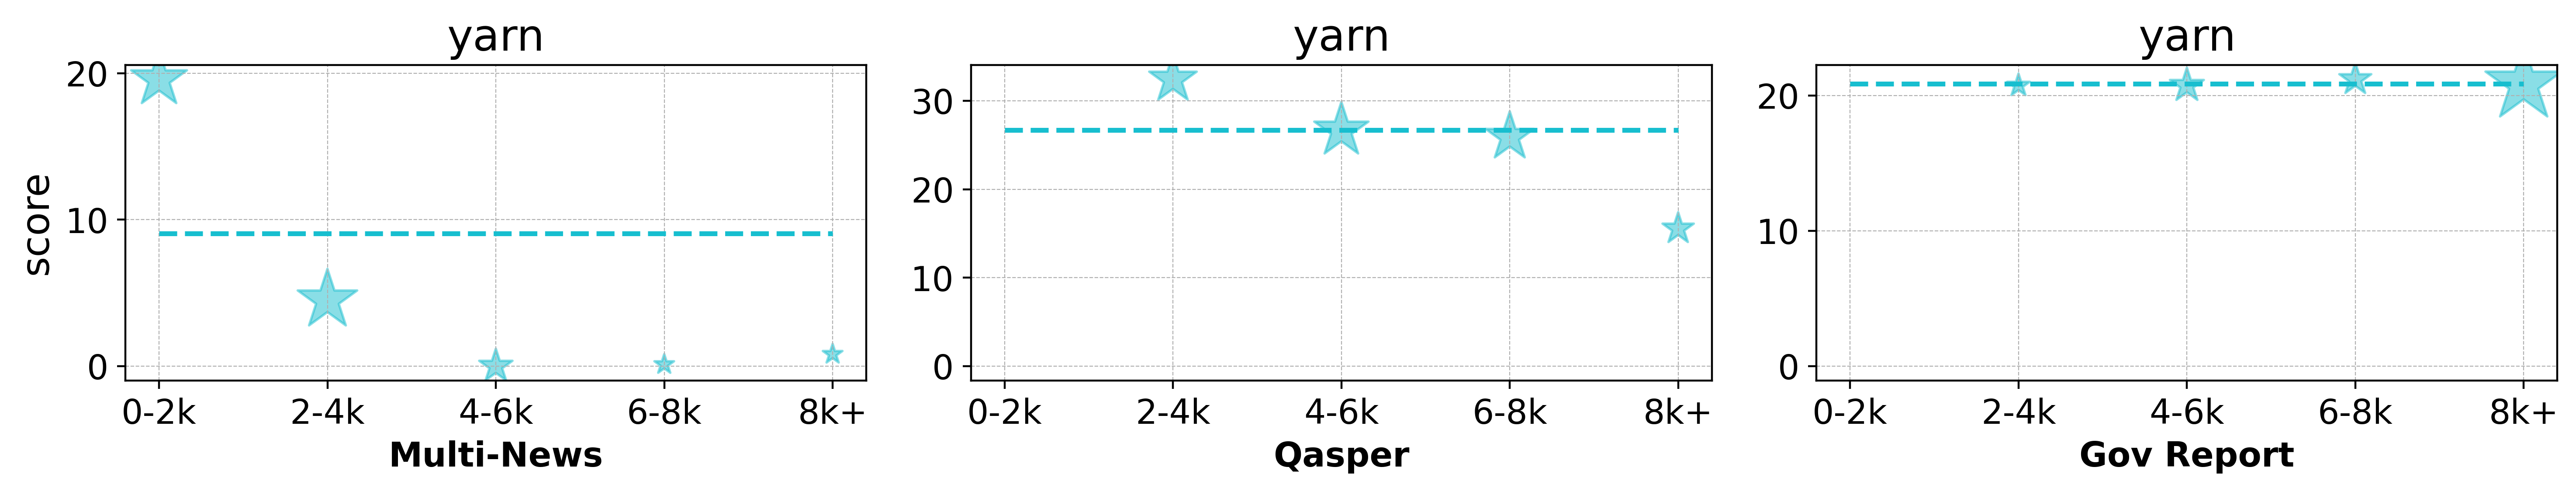

In [19]:
for model in path.keys():
    draw_longbench(model, dataset_re, results_all, show_tasks, x_map)

### Comparison between LLaMA 3.1-8B-Instruct and Qwen 2.5-7B-Instruct on the Counting Star task

In [4]:
paths = {
        'llama-3.1-8B':'llama-3.1-8B-Instruct',
        'llama-3.1-70B': 'llama-3.1-70B-Instruct' ,
         'llama-3.2-1B':'llama-3.2-1B-Instruct',
        'llama-3.2-3B':'llama-3.2-3B-Instruct',
        'phi-3-128k-mini1':'phi-3-mini-128k-instruct',
        'phi-3-128k-medium2':'phi-3-medium-128k-instruct',
         'Qwen2.5-7B':'Qwen2.5-7B-Instruct',
         'Qwen2.5-14B':'Qwen2.5-14B-Instruct',
         }
results = dict()
for k,p in paths.items():
    results[k] = json.load(open(os.path.join(set_global_path('./preds/pred_open_model') ,p,'result.json'), 'r'))

In [3]:
draw_tasks = get_results_per_task(results, lengths=[0, 8, 16, 32, 64, 128, 256])
print(draw_tasks)

defaultdict(<class 'dict'>, {'counting_stars': {'llama-3.1-8B': [(0, 60.61), (128, 38.0), (16, 56.0), (256, 29.0), (32, 53.0), (64, 55.0), (8, 50.0)], 'llama-3.1-70B': [(0, 84.85), (128, 30.0), (16, 71.0), (32, 64.0), (64, 48.0), (8, 73.0)], 'llama-3.2-1B': [(0, 40.4), (128, 17.0), (16, 33.0), (256, 13.0), (32, 31.0), (64, 24.0), (8, 24.0)], 'llama-3.2-3B': [(0, 46.46), (128, 38.0), (16, 38.0), (256, 31.0), (32, 31.0), (64, 36.0), (8, 35.0)], 'phi-3-128k-mini1': [(0, 52.53), (128, 38.0), (16, 53.0), (32, 46.0), (64, 39.0), (8, 40.0)], 'phi-3-128k-medium2': [(0, 63.64), (128, 38.0), (16, 48.0), (32, 46.0), (64, 48.0), (8, 49.0)], 'Qwen2.5-7B': [(128, 33.0), (16, 71.0), (256, 1.0), (32, 72.0), (64, 56.0), (8, 71.0), (0, 87.88)], 'Qwen2.5-14B': [(0, 87.88), (128, 55.0), (16, 75.0), (256, 3.0), (32, 74.0), (64, 62.0), (8, 73.0)]}, 'kv_retrieval': {'llama-3.1-8B': [(0, 58.59), (128, 71.0), (16, 56.0), (256, 23.0), (32, 67.0), (64, 75.0), (8, 61.0)], 'llama-3.1-70B': [(0, 75.76), (128, 70.0)

In [8]:
def draw_comparsion(draw_tasks, task ='counting_stars', save=False):
    plt.figure(figsize=(7, 3), dpi=300)
    # 为每种类型生成不同的颜色
    colors = plt.cm.get_cmap('tab10', 13)
    for m_i, (model, scores) in enumerate(draw_tasks[task].items()):
        if '8B' in model or '7B' in model:
            scores = sorted(scores, key=lambda x: x[0])
            x, y = [i for i, s_i in enumerate(scores)], [s_i[1] for s_i in scores]
            k = ['0-8k']+[f'{s_i[0]}k' for s_i in scores[1:]]
            baseline = np.mean(y)
            print(baseline)
            plt.plot(x, [baseline]*len(y), color=colors(m_i), linestyle='--', alpha=0.5, label=f'{change_name(model)} Avg')
            # 创建折线图
            plt.plot(x, y, color=colors(m_i), alpha=0.5)  # 绘制灰色折线
            # 绘制每个点，并根据类型分配颜色
            plt.scatter(x, y, color=colors(m_i), label=f'{change_name(model)}', s=100)
    # plt.legend(loc='best', title="dataset", framealpha=0.3)
    # plt.legend(loc='lower left', framealpha=0.3)
    plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.35), fontsize=14)
    # plt.title(task)
    # plt.xlabel("length")
    plt.ylabel("score")
    plt.xticks(x, k)
    # plt.grid(0.2)
    plt.grid(True, linestyle='--', linewidth=0.4)
    if save: plt.savefig("changes.pdf", format="pdf", dpi=600, bbox_inches="tight")
    plt.show()

48.80142857142857
55.98285714285714


/tmp/ipykernel_3454271/1317840010.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', 13)


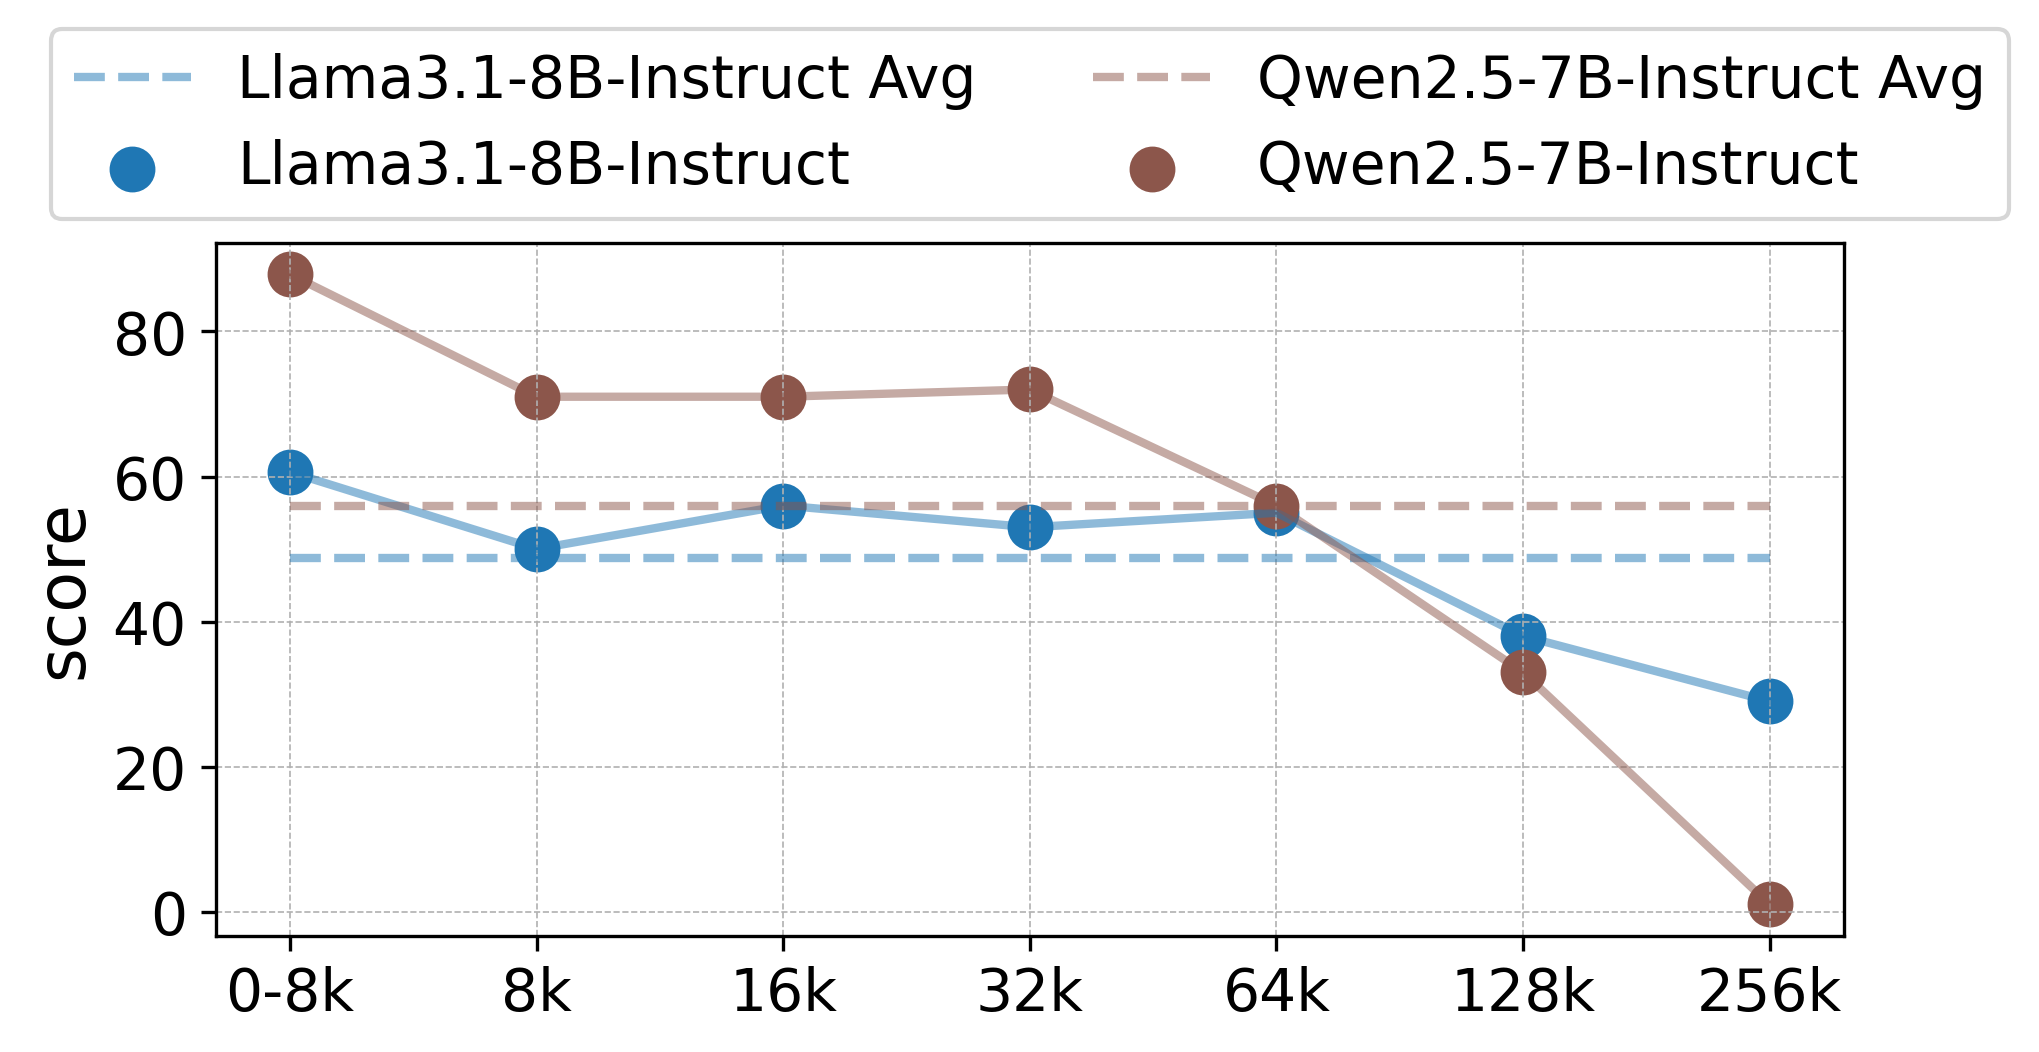

In [9]:
draw_comparsion(draw_tasks)

## Veification

### Verification of the reliability of the proposed benchmark

In [2]:
paths = {
        'llama-3.1-8B':'llama-3.1-8B-Instruct',
        'llama-3.1-70B': 'llama-3.1-70B-Instruct' ,
         'llama-3.2-1B':'llama-3.2-1B-Instruct',
        'llama-3.2-3B':'llama-3.2-3B-Instruct',
        'phi-3-128k-mini1':'phi-3-mini-128k-instruct',
        'phi-3-128k-medium2':'phi-3-medium-128k-instruct',
         'Qwen2.5-7B':'Qwen2.5-7B-Instruct',
         'Qwen2.5-14B':'Qwen2.5-14B-Instruct',
         }
results = dict()
for k,p in paths.items():
    results[k] = json.load(open(os.path.join(set_global_path('./preds/pred_open_model') ,p,'result.json'), 'r'))

In [3]:
draw_series = { 'llama-3.2':{}, 'llama-3.1':{}, 'phi-3':{}} # ,'Qwen2.5':{}, 
for model in results.keys():
    draw_things = defaultdict(list)
    for dataset,score in results[model].items():
        name = dataset.split('_')
        name, x = '_'.join(name[:-1]), int(name[-1])
        draw_things[name].append((x, score))
    draw_things = {key: draw_things[key] for key in sorted(draw_things)}
    for se in draw_series.keys():
        if se in model: draw_series[se][model] = draw_things
print(draw_series)

{'llama-3.2': {'llama-3.2-1B': {'counting_stars': [(0, 40.4), (128, 17.0), (16, 33.0), (256, 13.0), (32, 31.0), (64, 24.0), (8, 24.0)], 'kv_retrieval': [(0, 58.59), (128, 59.0), (16, 45.0), (256, 47.0), (32, 58.0), (64, 64.0), (8, 60.0)], 'multi_doc_qa': [(0, 29.17), (128, 20.65), (16, 29.32), (256, 15.0), (32, 25.37), (64, 23.99), (8, 31.42)], 'multi_doc_sum': [(0, 20.89), (128, 0.75), (16, 7.66), (256, 0.0), (32, 3.6), (64, 1.28), (8, 12.18)], 'passage_count': [(0, 4.04), (128, 4.0), (16, 13.0), (256, 1.0), (32, 7.0), (64, 5.0), (8, 16.0)], 'passage_retrieval': [(0, 25.25), (128, 2.0), (16, 13.0), (256, 2.0), (32, 10.0), (64, 3.0), (8, 17.0)], 'single_doc_qa': [(0, 32.42), (128, 18.07), (16, 24.02), (256, 13.1), (32, 20.49), (64, 20.58), (8, 29.81)], 'single_doc_sum': [(0, 19.26), (128, 4.18), (16, 8.41), (256, 2.4), (32, 6.23), (64, 7.77), (8, 17.13)]}, 'llama-3.2-3B': {'counting_stars': [(0, 46.46), (128, 38.0), (16, 38.0), (256, 31.0), (32, 31.0), (64, 36.0), (8, 35.0)], 'kv_retri

In [4]:
from matplotlib.colors import LinearSegmentedColormap

def draw_bar(save=False):
    bar_width = 0.35
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    colors = ['#1f77b4', '#ff7f0e']

    for se_i, (series, result) in enumerate(draw_series.items()):
        ax = axes[se_i]
        data = dict()
        for model, scores in result.items():
            data[model] = dict()
            for dataset, all_s in scores.items():
                data[model][dataset] = [s[-1] for s in all_s]
        models = list(data.keys())
        tasks = list(data[model].keys())
        index = np.arange(len(tasks))
        for i, task in enumerate(tasks):
            # print(data[models[0]][task])
            score_7b = sum(data[models[0]][task])/len(data[models[0]][task])
            score_14b = sum(data[models[1]][task]) /len(data[models[0]][task])
            ax.bar(index[i] - bar_width/2, score_7b, bar_width, label=change_name(models[0]) if i ==0 else '', color=colors[0])
            ax.bar(index[i] + bar_width/2, score_14b, bar_width, label=change_name(models[1]) if i ==0 else '' , color=colors[1])

        if se_i == 0: ax.set_ylabel('Average Score')
        ax.set_xticks(index)
        ax.set_xticklabels([change_name(t) for t in tasks], rotation=45, ha='right')

        ax.legend(loc='upper left', framealpha=0.3, fontsize=14)
    plt.tight_layout()
    if save: plt.savefig("verfication_bar.pdf", format="pdf", dpi=600, bbox_inches="tight")
    plt.show()

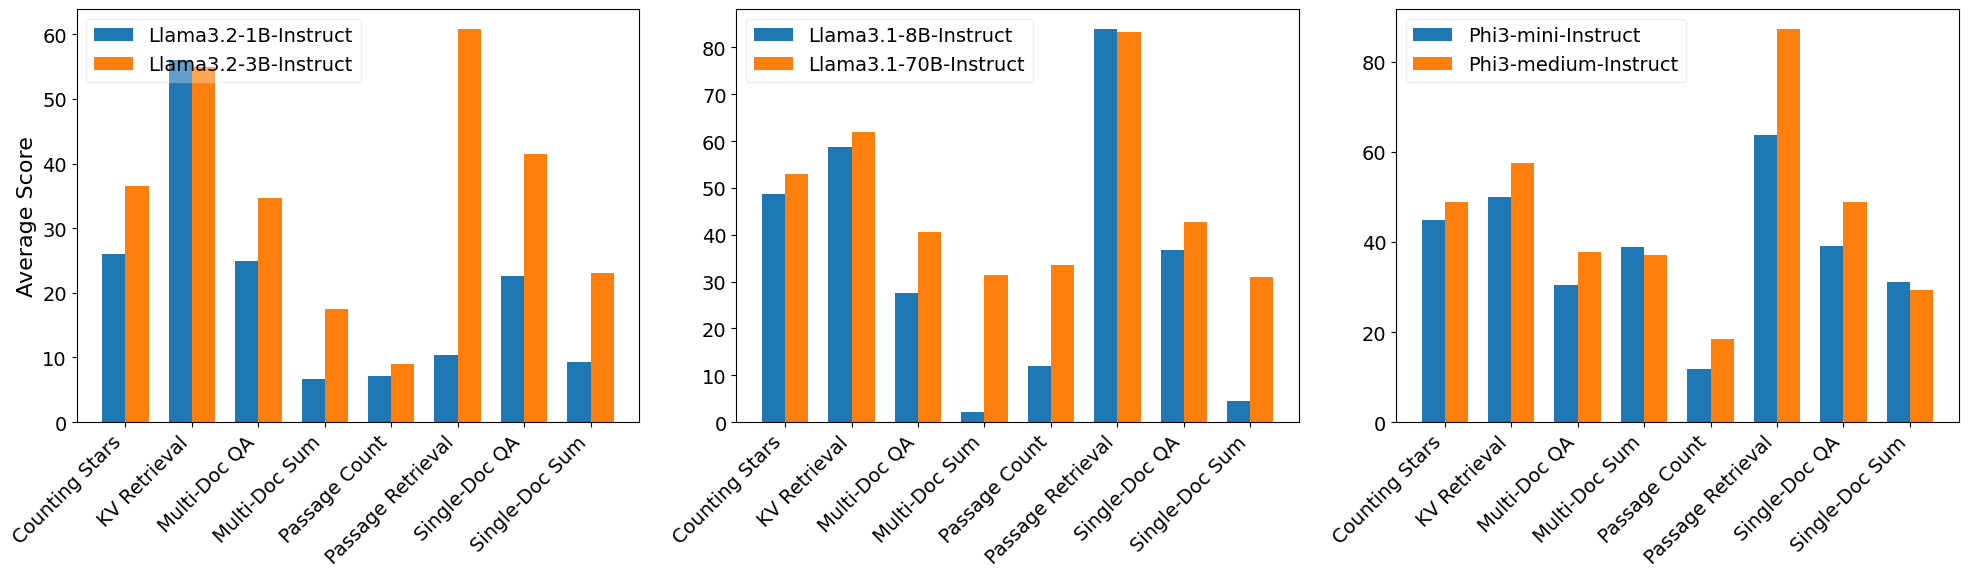

In [6]:
draw_bar()

In [9]:
def draw_line(save=False):
    fig, axes = plt.subplots(1, 3, figsize=(25, 6), sharex=True, sharey=True)
    colors, datasets = plt.cm.get_cmap('tab10', 8), set()
    x_t, k = None, None
    linestyles, markers = ['--', '-'], ['*','o',]
    for s_i, se in enumerate(draw_series.keys()):
        ax = axes[s_i]
        for m_i, (model, draw_things) in enumerate(draw_series[se].items()):
            size = model.split('-')[-1]
            for i, (dataset,scores) in enumerate(draw_things.items()):
                datasets.add(dataset)
                scores = sorted(scores, key=lambda x: x[0])
                x, y = [i for i, s_i in enumerate(scores)], [s_i[1] for s_i in scores]
                if k is None or x_t is None or len(k) < len(y):
                    x_t = x
                    k = ['0-8k']+[f'{s_i[0]}k' for s_i in scores[1:]]
                ax.plot(x, y, label=f'{size}' if i ==0 else "", color=colors(i), marker=markers[m_i], linestyle=linestyles[m_i], ms=13)
                # ax.scatter(x, y, label=f'{size}' if i ==0 else "", color=colors(i), marker=markers[m_i], s=200)
            ax.set_xlabel(f'{se} Instruct', fontsize=18, fontweight='bold',)
            ax.set_ylabel("Scores", fontsize=14)
            ax.set_xticks(x_t, k)
            ax.grid(True, linestyle='--', linewidth=0.4)
            ax.legend(fontsize=18, framealpha=0.3, loc='upper right')
            plt.legend()

    handles = [plt.Line2D([0], [0], color=colors(i), linestyle='-', linewidth=2, label=task) for i, task in enumerate(datasets)]
    fig.legend(handles, [change_name(i) for i in list(draw_things.keys())] , loc='upper center', ncol=len(draw_things.keys()), fontsize=18, bbox_to_anchor=(0.5, 1.0))

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)  
    if save: plt.savefig("verfication.pdf", format="pdf", dpi=600, bbox_inches="tight")
    plt.show()

/tmp/ipykernel_494449/2909710307.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors, datasets = plt.cm.get_cmap('tab10', 8), set()
/tmp/ipykernel_494449/2909710307.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_494449/2909710307.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_494449/2909710307.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipy

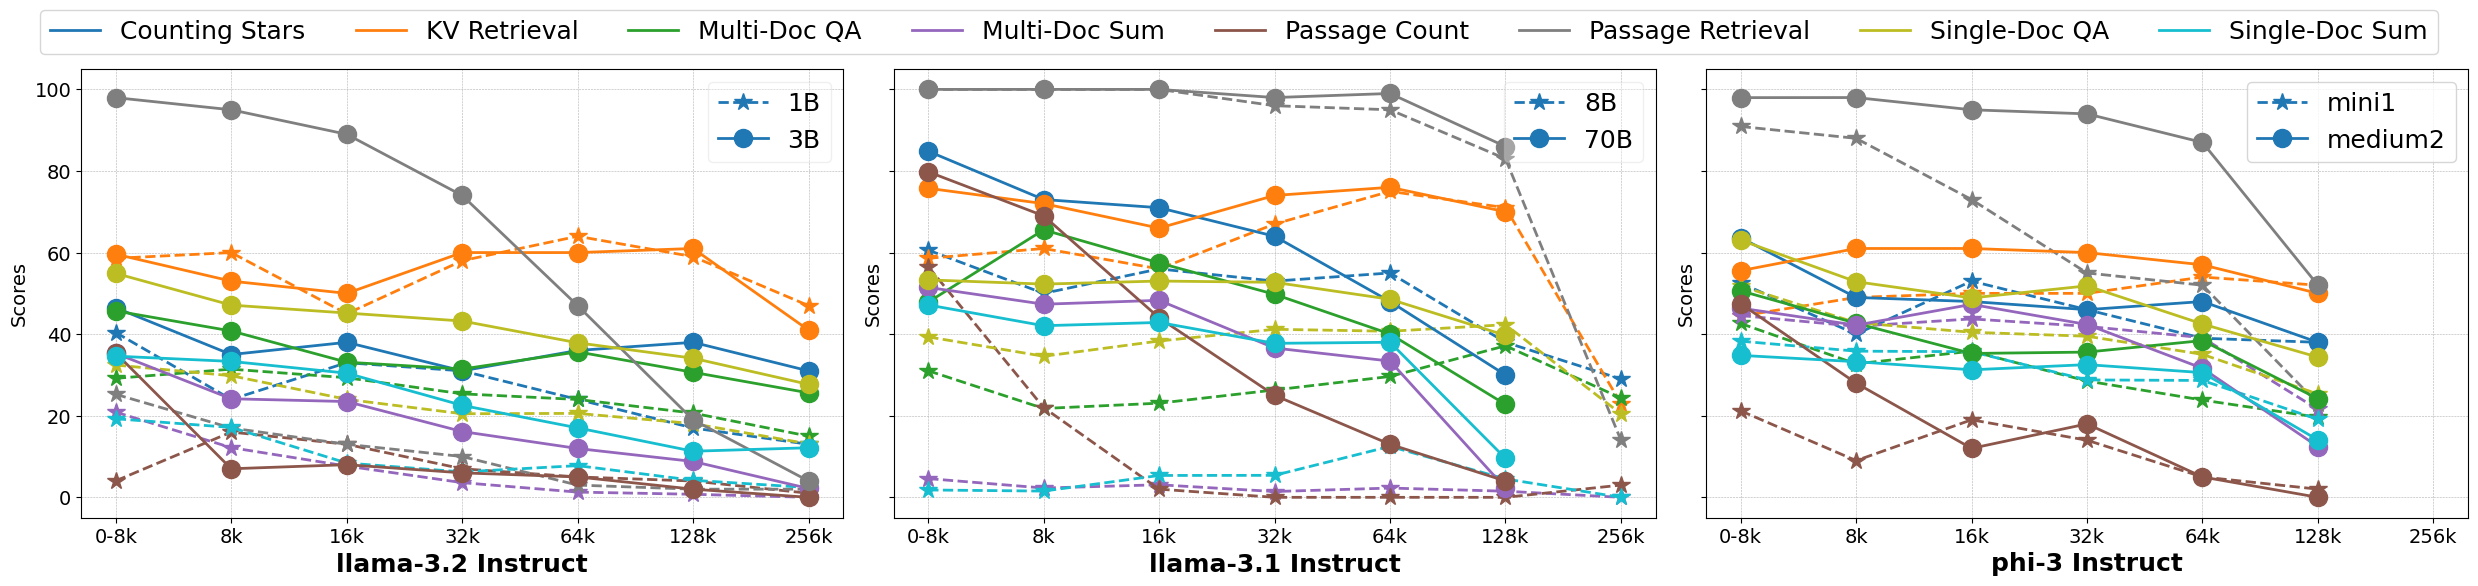

In [10]:
draw_line()

### Verification of the effectiveness of the proposed metric

#### average socres on longbench

In [13]:
path = {
        'ntk':'llama2-7b-hf-slimpajama-ntk-32k', 
        'pi': 'llama2-7b-hf-slimpajama-pi-32k',
        }
results, results_all = dict(), dict()
for model, p in path.items():
    results[model]= json.load(open(os.path.join(set_global_path('./preds/pred_longbench'), p,'result.json'), 'r'))
    results_all[model]= json.load(open(os.path.join(set_global_path('./preds/pred_longbench'), p,'result_all.json'), 'r'))


In [14]:
for method, scores in results_all.items():
    print(f"{method}'s avgerage score: {sum(scores.values())/len(scores.values())}")

ntk's avgerage score: 34.980625
pi's avgerage score: 33.311875


#### avearge socres on 100-longbench

In [15]:
paths = {
        'llama2-7b-ntk':'llama2-7b-hf-slimpajama-ntk-32k',
         'llama2-7b-pi':'llama2-7b-hf-slimpajama-pi-32k',
         }
lengths=[0,8,16,24,31,48, 64]
results = dict()
for k,p in paths.items():
    results[k] = json.load(open(os.path.join(set_global_path('./preds/pred_base'), p,'result_original.json'), 'r'))


In [16]:
draw_tasks = get_results_per_task(results)
print(draw_tasks)

defaultdict(<class 'dict'>, {'counting_stars': {'llama2-7b-ntk': [(0, 21.0), (16, 17.0), (24, 30.0), (31, 31.0), (48, 23.0), (64, 26.0), (8, 27.0)], 'llama2-7b-pi': [(0, 10.0), (16, 15.0), (24, 24.0), (31, 29.0), (48, 0.0), (64, 0.0), (8, 22.0)]}, 'kv_retrieval': {'llama2-7b-ntk': [(0, 51.0), (16, 53.0), (24, 57.0), (31, 56.0), (48, 44.0), (64, 34.0), (8, 57.0)], 'llama2-7b-pi': [(0, 54.0), (16, 60.0), (24, 63.0), (31, 57.0), (48, 0.0), (64, 0.0), (8, 62.0)]}, 'multi_doc_qa': {'llama2-7b-ntk': [(0, 8.58), (16, 11.3), (24, 7.66), (31, 10.78), (48, 6.77), (64, 8.71), (8, 4.38)], 'llama2-7b-pi': [(0, 16.66), (16, 11.68), (24, 11.24), (31, 9.28), (48, 1.16), (64, 0.0), (8, 7.13)]}, 'multi_doc_sum': {'llama2-7b-ntk': [(0, 1.84), (16, 2.47), (24, 4.23), (31, 3.5), (48, 4.99), (64, 5.5), (8, 2.44)], 'llama2-7b-pi': [(0, 4.35), (16, 6.69), (24, 6.07), (31, 4.89), (48, 1.24), (64, 0.05), (8, 3.18)]}, 'passage_count': {'llama2-7b-ntk': [(0, 10.0), (16, 4.0), (24, 1.0), (31, 3.0), (48, 1.0), (64,

In [19]:
for task in draw_tasks.keys():
    print(f"==============================  {task}  ==============================\n")
    original_performances, new_performances = rank(draw_tasks[task], all_steps=lengths)
    print("======================================================================\n")

==============================  counting_stars  ==============================

original_metrics
                 0     8     16    24    31    48    64    -1 
llama2-7b-ntk  21.0  27.0  17.0  30.0  31.0  23.0  26.0  25.67
llama2-7b-pi   10.0  22.0  15.0  24.0  29.0   0.0   0.0  15.00


original_ranking
                0    8    16   24   31   48   64  -1 
llama2-7b-ntk    1    1    1    1    1    1    1    1
llama2-7b-pi     2    2    2    2    2    2    2    2


new_metrics
                0       8      16      24      31      48      64    -1 
llama2-7b-ntk  0.0   28.57 -19.05   42.86   47.62    9.52   23.81  22.22
llama2-7b-pi   0.0  120.00  50.00  140.00  190.00 -100.00 -100.00  50.00


new_ranking
                0    8    16   24   31   48   64  -1 
llama2-7b-ntk    1    2    2    2    2    1    1    2
llama2-7b-pi     1    1    1    1    1    2    2    1



==============================  kv_retrieval  ==============================

original_metrics
                 0     8  

In [20]:
model_average_results = get_model_avg(draw_tasks, lengths=lengths)
print(f"==============================  avg  ==============================\n")
original_performances, new_performances = rank(model_average_results, all_steps=lengths)
print(f"===================================================================\n")

==============================  avg  ==============================

original_metrics
                     0         8         16        24       31        48  \
llama2-7b-ntk  19.39875  15.72875  16.53125  16.70250  17.1775  12.88500   
llama2-7b-pi   19.18375  16.47125  17.67375  17.10875  17.6750   0.44125   

                     64    -1   
llama2-7b-ntk  13.20625  15.37  
llama2-7b-pi    0.00625  11.56  


original_ranking
                0    8    16   24   31   48   64  -1 
llama2-7b-ntk    1    2    2    2    2    1    1    1
llama2-7b-pi     2    1    1    1    1    2    2    2


new_metrics
                0      8      16     24     31     48     64    -1 
llama2-7b-ntk  0.0 -18.92 -14.78 -13.90 -11.45 -33.58 -31.92 -20.76
llama2-7b-pi   0.0 -14.14  -7.87 -10.82  -7.86 -97.70 -99.97 -39.73


new_ranking
                0    8    16   24   31   48   64  -1 
llama2-7b-ntk    1    2    2    2    2    1    1    1
llama2-7b-pi     1    1    1    1    1    2    2    2





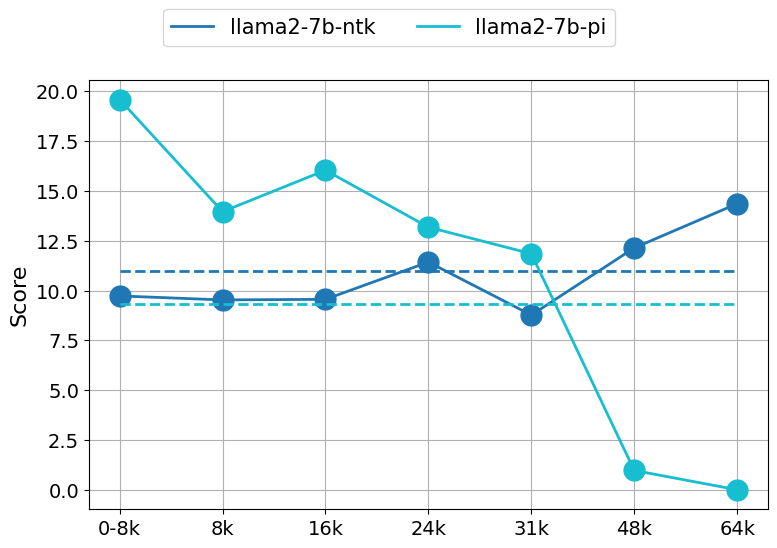

In [18]:
draw_avg_line(original_performances, lengths)